# 计时器(实际完成的整体代码)

In [1]:
import time
import warnings
from contextlib import contextmanager

import torch


class TimeCounter:
    names = dict()

    # Avoid instantiating every time
    @classmethod
    def count_time(cls, log_interval=1, warmup_interval=1, with_sync=True):
        assert warmup_interval >= 1

        def _register(func):
            if func.__name__ in cls.names:
                raise RuntimeError(
                    'The registered function name cannot be repeated!')
            # When adding on multiple functions, we need to ensure that the
            # data does not interfere with each other
            cls.names[func.__name__] = dict(
                count=0,
                pure_inf_time=0,
                log_interval=log_interval,
                warmup_interval=warmup_interval,
                with_sync=with_sync)

            def fun(*args, **kwargs):
                count = cls.names[func.__name__]['count']
                pure_inf_time = cls.names[func.__name__]['pure_inf_time']
                log_interval = cls.names[func.__name__]['log_interval']
                warmup_interval = cls.names[func.__name__]['warmup_interval']
                with_sync = cls.names[func.__name__]['with_sync']

                count += 1
                cls.names[func.__name__]['count'] = count

                if with_sync and torch.cuda.is_available():
                    torch.cuda.synchronize()
                start_time = time.perf_counter()

                result = func(*args, **kwargs)

                if with_sync and torch.cuda.is_available():
                    torch.cuda.synchronize()

                elapsed = time.perf_counter() - start_time

                if count >= warmup_interval:
                    pure_inf_time += elapsed
                    cls.names[func.__name__]['pure_inf_time'] = pure_inf_time

                    if count % log_interval == 0:
                        times_per_count = 1000 * pure_inf_time / (
                            count - warmup_interval + 1)
                        print(
                            f'[{func.__name__}]-{count} times per count: '
                            f'{times_per_count:.1f} ms',
                            flush=True)

                return result

            return fun

        return _register

    @classmethod
    @contextmanager
    def profile_time(cls,
                     func_name,
                     log_interval=1,
                     warmup_interval=1,
                     with_sync=True):
        assert warmup_interval >= 1
        warnings.warn('func_name must be globally unique if you call '
                      'profile_time multiple times')

        if func_name in cls.names:
            count = cls.names[func_name]['count']
            pure_inf_time = cls.names[func_name]['pure_inf_time']
            log_interval = cls.names[func_name]['log_interval']
            warmup_interval = cls.names[func_name]['warmup_interval']
            with_sync = cls.names[func_name]['with_sync']
        else:
            count = 0
            pure_inf_time = 0
            cls.names[func_name] = dict(
                count=count,
                pure_inf_time=pure_inf_time,
                log_interval=log_interval,
                warmup_interval=warmup_interval,
                with_sync=with_sync)

        count += 1
        cls.names[func_name]['count'] = count

        if with_sync and torch.cuda.is_available():
            torch.cuda.synchronize()
        start_time = time.perf_counter()

        yield

        if with_sync and torch.cuda.is_available():
            torch.cuda.synchronize()
        elapsed = time.perf_counter() - start_time

        if count >= warmup_interval:
            pure_inf_time += elapsed
            cls.names[func_name]['pure_inf_time'] = pure_inf_time

            if count % log_interval == 0:
                times_per_count = 1000 * pure_inf_time / (
                    count - warmup_interval + 1)
                print(
                    f'[{func_name}]-{count} times per count: '
                    f'{times_per_count:.1f} ms',
                    flush=True)

C:\Users\82516\.conda\envs\tf1\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 准备工作

In [2]:
# D:\a_study\model\chuneng\WindChaser-master - 副本\data
# 测试集和训练集的比例   7：3
import pandas as pd
import numpy as np
import tensorflow as tf

from sklearn.metrics import mean_absolute_error,mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from numpy import shape
import matplotlib.ticker as ticker
%matplotlib inline

import math

import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False

C:\Users\82516\.conda\envs\tf1\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\82516\.conda\envs\tf1\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\82516\.conda\envs\tf1\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\82516\.conda\envs\tf1\lib\site-packages\tensorflow\python\framework\dtypes.py:5

In [3]:
df = pd.read_csv('d1.csv', on_bad_lines='skip')
print("Length of original data : ", len(df))

# 计算每小时的平均值并另存为新数据帧
data2 =[]   
for i in range (len(df)//12):
    data2.append(df[i * 12:(i + 1) * 12].mean())
data2 = pd.DataFrame(data2)
print("Length of hourly averaged data : ", len(data2))

# 6-11列的数据
data = data2.iloc[:, 5:11].values

Length of original data :  17568
Length of hourly averaged data :  1464


In [4]:
# 查看位置
import os
print(os.path.abspath('.'))


D:\a_study\model\chuneng\WindChaser-master - 副本\data


In [5]:
rnn_unit = 10      #隐藏层单元
input_size = 5     # 表示输入层为5，数据为6-11列，实际使用7-11做输入预测6的结果，可以理解为输入层有5个节点
output_size=1      # 表示输出层的维度是1，实际输出第6列的结果
lr=0.0006         # 学习率

batch_size = 14   # 每个batch中样本的数量
time_step = 12    # 每个样本输入的时间步数

# 大概占0.68306，简单理解成训练集和测试集7：3
train_begin = 0
train_end = math.ceil(len(data2) * 0.7)
test_begin = math.ceil(len(data2) * 0.7)

test_len = 180   # 测试数据的长度
# iter_time = 100  # 迭代次数
iter_time = 100  # 迭代次数

# RNN 输出节点权重和偏差
# 决定rnn单元的输出和下一步的状态
weights = {
           'in':tf.Variable(tf.random.normal([input_size,rnn_unit])),
           'out':tf.Variable(tf.random.normal([rnn_unit,1]))
           }

biases = {
          'in':tf.Variable(tf.constant(0.1,shape=[rnn_unit,])),
          'out':tf.Variable(tf.constant(0.1,shape=[1,]))
          }


In [6]:
# 获取训练数据功能：加载 LSTM 的训练数据
# 输入: batch_size, time_step, train_begin, train_end
# 输出: batch_index, train_x, train_y

def get_train_data(batch_size, time_step, train_begin, train_end):
    batch_index = []
    
     
    
    # 规范化数据
    scaler_for_x = MinMaxScaler(feature_range=(0, 1))
    scaled_x_data = scaler_for_x.fit_transform(data)
    
    scaler_for_y = MinMaxScaler(feature_range=(0, 1))
    scaled_y_data = scaler_for_y.fit_transform(data[:, 0].reshape(-1, 1))
    

    # 获得训练数据
    normalized_train_data = scaled_x_data[train_begin:train_end]
    train_x, train_y = [], []
    for i in range(len(normalized_train_data) - time_step):
        if i % batch_size == 0:
            batch_index.append(i)
        x = normalized_train_data[i:i + time_step, 1:6]
        y = normalized_train_data[i+1:i + time_step+1, 0, np.newaxis]
        train_x.append(x.tolist())
        train_y.append(y.tolist())
    
    batch_index.append((len(normalized_train_data) - time_step))
    return batch_index, train_x, train_y 

In [7]:
# 获取测试数据功能：LSTM 的负载测试数据
# 输入: time_step, test_begin, test_len
# 输出: test_x, test_y, scaler_for_x, scaler_for_y

def get_test_data(time_step, test_begin, test_len):
    
    # 规范化数据
    scaler_for_x = MinMaxScaler(feature_range=(0, 1))   # 归一化处理 minmaxscaler
    scaler_for_y = MinMaxScaler(feature_range=(0, 1))
    scaled_x_data = scaler_for_x.fit_transform(data)
    scaled_y_data = scaler_for_y.fit_transform(data[:, 0].reshape(-1, 1))
    
    # 获得测试数据
    size = test_len// time_step    # 用于计算测试集数据的数量
    normalized_test_data = scaled_x_data[test_begin: (test_begin+test_len)]
    normalized_test_lable = scaled_x_data[test_begin+1: (test_begin+test_len+1)]
    test_y = normalized_test_lable[:,0]
    test_x = []
    for i in range(size):
        x = normalized_test_data[i * time_step:(i + 1) * time_step, 1:6]
        test_x.append(x.tolist())
    return test_x, test_y, scaler_for_x, scaler_for_y

# 1

In [8]:
# LSTM 函数：循环神经网络的定义 定义的是lstm层
# 输入: X
# 输出: pred, final_states

def lstm(X):
    batch_size = tf.shape(X)[0]
    time_step = tf.shape(X)[1]
    w_in = weights['in']
    b_in = biases['in']
    
    # reshape to (batch_size * time_step, input_size)
    input = tf.reshape(X, [-1, input_size])  #将张量转换为 3D 数组作为隐藏层的输入
    input_rnn = tf.matmul(input, w_in) + b_in
    input_rnn = tf.reshape(input_rnn, [-1, time_step, rnn_unit])
    
    # 创建要展开的 LSTM 单元
    cell = tf.contrib.rnn.BasicLSTMCell(rnn_unit)
    
    # 在每个时间步，重新初始化隐藏状态
    init_state = cell.zero_state(batch_size, dtype=tf.float32)
    
    # 生成预测
    # 在 TensorFlow 中创建一个动态 RNN 对象。
    # 此对象将在每个时间步长动态执行 LSTM 单元的展开
    output_rnn, final_states = tf.nn.dynamic_rnn(cell, input_rnn, initial_state=init_state,
                                                 dtype=tf.float32)
    
    output = tf.reshape(output_rnn, [-1, rnn_unit])
    w_out = weights['out']
    b_out = biases['out']
    ## 获取最后输出
    pred = tf.matmul(output, w_out) + b_out
    pred = tf.identity(pred, name='my_pred')  # 这里为 pred 操作指定一个新的名称
    
    return pred, final_states

In [9]:
# baocun
# train_lstm function: 训练 LSTM 模型、进行预测、计算预测误差
# 输入: batch_size, time_step, train_begin, train_end, test_begin, iter_time, test_len
# 输出: test_y, test_predict, loss_list, rmse, mae
# test_y：测试集，test_predict：预测值
@TimeCounter.count_time()
def train_lstm(batch_size, time_step, train_begin, train_end, test_begin, iter_time, test_len):
    # 设置状态存储/提取
    X = tf.placeholder(tf.float32, shape=[None, time_step, input_size], name='input_placeholder')
    # X = tf.placeholder(tf.float32, shape=[None, time_step, input_size])
    


    Y = tf.placeholder(tf.float32, shape=[None, time_step, output_size])    
    batch_index, train_x, train_y = get_train_data(batch_size, time_step, train_begin, train_end)
    
    pred, _ = lstm(X)
    
    pred = tf.identity(pred, name="pre_output")
    
    ## Loss and optimizer 损失和优化器
    loss = tf.reduce_mean(tf.square(tf.reshape(pred, [-1]) - tf.reshape(Y, [-1])))
    train_op = tf.train.AdamOptimizer(lr).minimize(loss)
    loss_list = []
    print("Training begins: *****************************************************")
    
    
    ## 训练步骤优化
    """
    累积损失以监控培训进度。
    20 次迭代通常足以达到可接受的精度。    
    """
    
    with tf.Session() as sess:
        # 初始化变量
        sess.run(tf.global_variables_initializer())
        # 重复训练 100 次
        for epoch in range(iter_time):
            for step in range(len(batch_index) - 2):
                ## 计算批量损失 loss
                _, loss_ = sess.run([train_op, loss], feed_dict={X: train_x[batch_index[step]:batch_index[step + 1]],
                                                                 Y: np.array(train_y[batch_index[step]:batch_index[step + 1]], dtype=float).reshape(batch_size,time_step,1)})
                loss_list.append(loss_)
            
            # Show loss every 5 iterations   
            if epoch % 5 == 0:
                print("Epoch:", epoch, " loss:",loss_)
            
                #if step%100==0:
                    #print('Epoch:', epoch, 'steps: ', step,  'loss:', loss_)
        
        # 生成了save_model文件夹,
        # D:\a_study\model\chuneng\WindChaser-master - 副本\saved_model
        saver = tf.train.Saver()

        # 保存模型
        saver.save(sess, 'saved_model1/model1')
        
        
        print("Training Optimization Finished! ***************************************")
          
        """Testing the model"""
        print("Prediction Begins: ****************************************************")
        test_x, test_y, scaler_for_x, scaler_for_y = get_test_data(time_step, test_begin, test_len)
        print("Shape of testing samples:", shape(test_x))

                      
        test_predict = []
        for step in range(len(test_x)):
            prob = sess.run(pred, feed_dict={X: [test_x[step]]})
            predict = prob.reshape((-1))
            test_predict.extend(predict)
        
        test_y = np.array(test_y).reshape(-1,1)
        test_predict = np.array(test_predict).reshape(-1,1) 
        print("Shape of testing lables:", shape(test_predict))
        test_predict = scaler_for_y.inverse_transform(test_predict).reshape(-1,1)
        test_y= scaler_for_y.inverse_transform(test_y).reshape(-1,1)
       
        
        # 计算预测误差 
        rmse = np.sqrt(mean_squared_error(test_predict, test_y))
        mae = mean_absolute_error(y_pred=test_predict, y_true=test_y)
        print ("Mean absolute error:", "{:.3f}".format(mae), 
               "Root mean squared error:", "{:.3f}".format(rmse))
        
        # 可视化
        figure = plt.figure(figsize=(8,5))
        
        axes = figure.add_subplot(1, 1, 1)
        axes.plot(test_y, lw='2', c = 'red', label='Real Testing Data')     
        axes.plot(test_predict, lw='2', c = 'darkblue', label='LSTM Forecasted Data')
        axes.set_title('Real Testing vs. Forecasted Wind Power', fontsize = 12)
        axes.set_xlabel('Time Series', fontsize = 12)
        axes.set_ylabel('Wind Power(MWh)', fontsize = 12)
       
        axes.legend(fontsize=12)
        

        
    return test_y, test_predict, loss_list, rmse, mae

In [10]:
# 不保存，只是测试
# train_lstm function: 训练 LSTM 模型、进行预测、计算预测误差
# 输入: batch_size, time_step, train_begin, train_end, test_begin, iter_time, test_len
# 输出: test_y, test_predict, loss_list, rmse, mae
# test_y：测试集，test_predict：预测值
@TimeCounter.count_time()

def train_lstm(batch_size, time_step, train_begin, train_end, test_begin, iter_time, test_len):
    # 设置状态存储/提取
    X = tf.placeholder(tf.float32, shape=[None, time_step, input_size], name='input_placeholder')
    # X = tf.placeholder(tf.float32, shape=[None, time_step, input_size])


    Y = tf.placeholder(tf.float32, shape=[None, time_step, output_size])    
    batch_index, train_x, train_y = get_train_data(batch_size, time_step, train_begin, train_end)
    
    pred, _ = lstm(X)
    
    ## Loss and optimizer 损失和优化器
    loss = tf.reduce_mean(tf.square(tf.reshape(pred, [-1]) - tf.reshape(Y, [-1])))
    train_op = tf.train.AdamOptimizer(lr).minimize(loss)
    loss_list = []
    print("Training begins: *****************************************************")
    
    
    ## 训练步骤优化
    """
    累积损失以监控培训进度。
    20 次迭代通常足以达到可接受的精度。    
    """
    
    with tf.Session() as sess:
        # 初始化变量
        sess.run(tf.global_variables_initializer())
        # 重复训练 100 次
        for epoch in range(iter_time):
            for step in range(len(batch_index) - 2):
                ## 计算批量损失 loss
                _, loss_ = sess.run([train_op, loss], feed_dict={X: train_x[batch_index[step]:batch_index[step + 1]],
                                                                 Y: np.array(train_y[batch_index[step]:batch_index[step + 1]], dtype=float).reshape(batch_size,time_step,1)})
                loss_list.append(loss_)
            
            # Show loss every 5 iterations   
            if epoch % 5 == 0:
                print("Epoch:", epoch, " loss:",loss_)
            
                #if step%100==0:
                    #print('Epoch:', epoch, 'steps: ', step,  'loss:', loss_)
        
       
        
        print("Training Optimization Finished! ***************************************")
          
        """Testing the model"""
        print("Prediction Begins: ****************************************************")
        test_x, test_y, scaler_for_x, scaler_for_y = get_test_data(time_step, test_begin, test_len)
        print("Shape of testing samples:", shape(test_x))

                      
        test_predict = []
        for step in range(len(test_x)):
            prob = sess.run(pred, feed_dict={X: [test_x[step]]})
            predict = prob.reshape((-1))
            test_predict.extend(predict)
        
        test_y = np.array(test_y).reshape(-1,1)
        test_predict = np.array(test_predict).reshape(-1,1) 
        print("Shape of testing lables:", shape(test_predict))
        test_predict = scaler_for_y.inverse_transform(test_predict).reshape(-1,1)
        test_y= scaler_for_y.inverse_transform(test_y).reshape(-1,1)
       
        
        # 计算预测误差 
        rmse = np.sqrt(mean_squared_error(test_predict, test_y))
        mae = mean_absolute_error(y_pred=test_predict, y_true=test_y)
        print ("Mean absolute error:", "{:.3f}".format(mae), 
               "Root mean squared error:", "{:.3f}".format(rmse))
        
        # 可视化
        figure = plt.figure(figsize=(8,5))
        
        axes = figure.add_subplot(1, 1, 1)
        axes.plot(test_y, lw='2', c = 'red', label='Real Testing Data')     
        axes.plot(test_predict, lw='2', c = 'darkblue', label='LSTM Forecasted Data')
        axes.set_title('Real Testing vs. Forecasted Wind Power', fontsize = 12)
        axes.set_xlabel('Time Series', fontsize = 12)
        axes.set_ylabel('Wind Power(MWh)', fontsize = 12)
       
        axes.legend(fontsize=12)
        

        
    return test_y, test_predict, loss_list, rmse, mae

RuntimeError: The registered function name cannot be repeated!


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor

Training begins: *****************************************************


Epoch: 0  loss: 0.020929256
Epoch: 5  loss: 0.009241697
Epoch: 10  loss: 0.004560311
Epoch: 15  loss

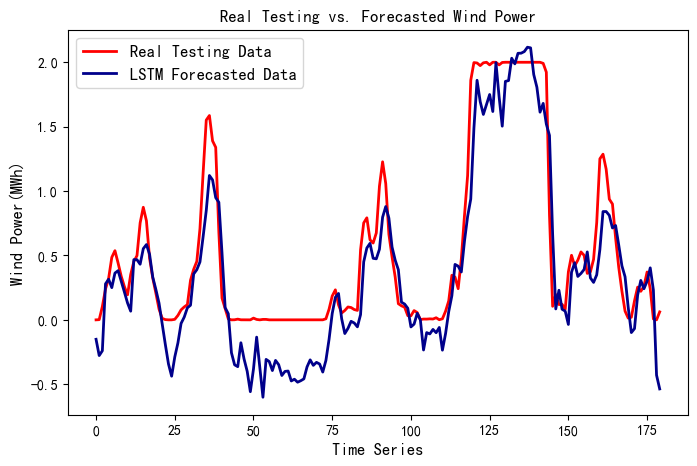

In [10]:
test_y, test_predict, loss_list, rmse, mae = train_lstm(batch_size, time_step, train_begin, train_end, test_begin, iter_time, test_len)

# 2

In [2]:
# D:\a_study\model\chuneng\WindChaser-master - 副本\data
# 测试集和训练集的比例   7：3
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.metrics import mean_absolute_error,mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from numpy import shape
import matplotlib.ticker as ticker
%matplotlib inline
import math
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False

C:\Users\82516\.conda\envs\tf1\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\82516\.conda\envs\tf1\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\82516\.conda\envs\tf1\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\82516\.conda\envs\tf1\lib\site-packages\tensorflow\python\framework\dtypes.py:5

In [3]:
# 设置 TensorFlow 配置
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True  # 根据需要分配 GPU 内存

# 清理计算图
tf.compat.v1.reset_default_graph()

# 创建新的计算图
graph = tf.Graph()

In [4]:
# df = pd.read_csv('data5_6.csv', on_bad_lines='skip')
df = pd.read_csv('data6.csv', on_bad_lines='skip')

print("Length of original data : ", len(df))

# 计算每小时的平均值并另存为新数据帧
data2 =[]   
for i in range (len(df)//12):
    data2.append(df[i * 12:(i + 1) * 12].mean())
data2 = pd.DataFrame(data2)
print("Length of hourly averaged data : ", len(data2))

# 6-11列的数据
data= data2.iloc[:, 5:11].values

Length of original data :  17568
Length of hourly averaged data :  1464


In [5]:
rnn_unit = 10      #隐藏层单元
input_size = 5     # 表示输入层为5，数据为6-11列，实际使用7-11做输入预测6的结果，可以理解为输入层有5个节点
output_size=1      # 表示输出层的维度是1，实际输出第6列的结果
lr=0.0006         # 学习率

batch_size = 14   # 每个batch中样本的数量
time_step = 12    # 每个样本输入的时间步数

# 大概占0.68306，简单理解成训练集和测试集7：3
train_begin = 0
train_end = math.ceil(len(data2) * 0.7)
test_begin = math.ceil(len(data2) * 0.7)

test_len = 180   # 测试数据的长度
# iter_time = 100  # 迭代次数
iter_time = 100  # 迭代次数

# RNN 输出节点权重和偏差
# 决定rnn单元的输出和下一步的状态
weights = {
           'in':tf.Variable(tf.random.normal([input_size,rnn_unit])),
           'out':tf.Variable(tf.random.normal([rnn_unit,1]))
           }

biases = {
          'in':tf.Variable(tf.constant(0.1,shape=[rnn_unit,])),
          'out':tf.Variable(tf.constant(0.1,shape=[1,]))
          }


In [6]:
# 获取训练数据功能：加载 LSTM 的训练数据
# 输入: batch_size, time_step, train_begin, train_end
# 输出: batch_index, train_x, train_y

def get_train_data(batch_size, time_step, train_begin, train_end):
    batch_index = []
    
     
    
    # 规范化数据
    scaler_for_x = MinMaxScaler(feature_range=(0, 1))
    scaled_x_data = scaler_for_x.fit_transform(data)
    
    scaler_for_y = MinMaxScaler(feature_range=(0, 1))
    scaled_y_data = scaler_for_y.fit_transform(data[:, 0].reshape(-1, 1))
    
    # 获得训练数据
    normalized_train_data = scaled_x_data[train_begin:train_end]
    train_x, train_y = [], []
    for i in range(len(normalized_train_data) - time_step):
        if i % batch_size == 0:
            batch_index.append(i)
        x = normalized_train_data[i:i + time_step, 1:6]
        y = normalized_train_data[i+1:i + time_step+1, 0, np.newaxis]
        train_x.append(x.tolist())
        train_y.append(y.tolist())
    
    batch_index.append((len(normalized_train_data) - time_step))
    return batch_index, train_x, train_y 

In [7]:
# 获取测试数据功能：LSTM 的负载测试数据
# 输入: time_step, test_begin, test_len
# 输出: test_x, test_y, scaler_for_x, scaler_for_y

def get_test_data(time_step, test_begin, test_len):
    
    # 规范化数据
    scaler_for_x = MinMaxScaler(feature_range=(0, 1))   # 归一化处理 minmaxscaler
    scaler_for_y = MinMaxScaler(feature_range=(0, 1))
    scaled_x_data = scaler_for_x.fit_transform(data)
    scaled_y_data = scaler_for_y.fit_transform(data[:, 0].reshape(-1, 1))
    
    # 获得测试数据
    size = test_len// time_step    # 用于计算测试集数据的数量
    normalized_test_data = scaled_x_data[test_begin: (test_begin+test_len)]
    normalized_test_lable = scaled_x_data[test_begin+1: (test_begin+test_len+1)]
    test_y = normalized_test_lable[:,0]
    test_x = []
    for i in range(size):
        x = normalized_test_data[i * time_step:(i + 1) * time_step, 1:6]
        test_x.append(x.tolist())
    return test_x, test_y, scaler_for_x, scaler_for_y

In [8]:
# LSTM 函数：循环神经网络的定义
# 输入: X
# 输出: pred, final_states

def lstm(X):
    batch_size = tf.shape(X)[0]
    time_step = tf.shape(X)[1]
    w_in = weights['in']
    b_in = biases['in']
    
    # reshape to (batch_size * time_step, input_size)
    input = tf.reshape(X, [-1, input_size])  #将张量转换为 3D 数组作为隐藏层的输入
    input_rnn = tf.matmul(input, w_in) + b_in
    input_rnn = tf.reshape(input_rnn, [-1, time_step, rnn_unit])
    
    # 创建要展开的 LSTM 单元
    cell = tf.contrib.rnn.BasicLSTMCell(rnn_unit)
    
    # 在每个时间步，重新初始化隐藏状态
    init_state = cell.zero_state(batch_size, dtype=tf.float32)
    
    # 生成预测
    # 在 TensorFlow 中创建一个动态 RNN 对象。
    # 此对象将在每个时间步长动态执行 LSTM 单元的展开
    output_rnn, final_states = tf.nn.dynamic_rnn(cell, input_rnn, initial_state=init_state,
                                                 dtype=tf.float32)
    
    output = tf.reshape(output_rnn, [-1, rnn_unit])
    w_out = weights['out']
    b_out = biases['out']
    ## 获取最后输出
    pred = tf.matmul(output, w_out) + b_out
    return pred, final_states

In [9]:
# baocun
# train_lstm function: 训练 LSTM 模型、进行预测、计算预测误差
# 输入: batch_size, time_step, train_begin, train_end, test_begin, iter_time, test_len
# 输出: test_y, test_predict, loss_list, rmse, mae
# test_y：测试集，test_predict：预测值
@TimeCounter.count_time()
def train_lstm(batch_size, time_step, train_begin, train_end, test_begin, iter_time, test_len):
    # 设置状态存储/提取
    X = tf.placeholder(tf.float32, shape=[None, time_step, input_size], name='input_placeholder')
    Y = tf.placeholder(tf.float32, shape=[None, time_step, output_size])    
    batch_index, train_x, train_y = get_train_data(batch_size, time_step, train_begin, train_end)
    
    pred, _ = lstm(X)
    
    ## Loss and optimizer 损失和优化器
    loss = tf.reduce_mean(tf.square(tf.reshape(pred, [-1]) - tf.reshape(Y, [-1])))
    train_op = tf.train.AdamOptimizer(lr).minimize(loss)
    loss_list = []
    print("Training begins: *****************************************************")
    
    
    ## 训练步骤优化
    """
    累积损失以监控培训进度。
    20 次迭代通常足以达到可接受的精度。    
    """
    
    with tf.Session() as sess:
        # 初始化变量
        sess.run(tf.global_variables_initializer())
        
        
        
        
        
        # 读取上次的模型的参数
        saver = tf.compat.v1.train.import_meta_graph('./saved_model5/model5.meta')
        save_path = './saved_model5/model5'
        
        
        
        
        
        
        
        # 恢复原始模型的权重
        saver.restore(sess=sess, save_path=save_path)
        # 获取原始模型的输入占位符、输出节点等  input_placeholder  my_pred
        graph = tf.compat.v1.get_default_graph()
        original_input = tf.compat.v1.get_default_graph().get_tensor_by_name('input_placeholder:0')  
        # 重复训练 100 次
        for epoch in range(iter_time):
            for step in range(len(batch_index) - 2):
                ## 计算批量损失 loss
                _, loss_ = sess.run([train_op, loss], feed_dict={X: train_x[batch_index[step]:batch_index[step + 1]],
                                                                 Y: np.array(train_y[batch_index[step]:batch_index[step + 1]], dtype=float).reshape(batch_size,time_step,1)})
                loss_list.append(loss_)
            
            # Show loss every 5 iterations   
            if epoch % 5 == 0:
                print("Epoch:", epoch, " loss:",loss_)
            
                #if step%100==0:
                    #print('Epoch:', epoch, 'steps: ', step,  'loss:', loss_)
        
        
        
        
        
        
        
        
        # 创建一个新的 Saver 对象
        # saver_ceshi = tf.compat.v1.train.Saver()
        # saver_ceshi = tf.train.Saver({'weights': weights, 'biases': biases})
        saver_6 = tf.train.Saver({'in': weights['in'], 'out': weights['out'], 'biases_in': biases['in'], 'biases_out': biases['out']})
        # saver_ceshi = tf.train.Saver(var_list={'weights': weights, 'biases': biases})
        # saver_ceshi = tf.train.Saver(var_list=[weights, biases])
        # saver_ceshi = tf.compat.v1.train.Checkpoint()
        # saver_ceshi = tf.train.Checkpoint()   # 这是tf2.0版本的写法
        # 保存模型到新路径
        # 下面是测试的
        # save_pathceshi = './saved_model_ceshi/modelceshi'
        # saver_ceshi.save(sess, save_pathceshi)
        save_path6 = './saved_model6/model6'
        saver_6.save(sess, save_path6)

        
        
        
        
        
        
        
        


        
        print("Training Optimization Finished! ***************************************")
          
        """Testing the model"""
        print("Prediction Begins: ****************************************************")
        test_x, test_y, scaler_for_x, scaler_for_y = get_test_data(time_step, test_begin, test_len)
        print("Shape of testing samples:", shape(test_x))

                      
        test_predict = []
        for step in range(len(test_x)):
            prob = sess.run(pred, feed_dict={X: [test_x[step]]})
            predict = prob.reshape((-1))
            test_predict.extend(predict)
        
        test_y = np.array(test_y).reshape(-1,1)
        test_predict = np.array(test_predict).reshape(-1,1) 
        print("Shape of testing lables:", shape(test_predict))
        test_predict = scaler_for_y.inverse_transform(test_predict).reshape(-1,1)
        test_y= scaler_for_y.inverse_transform(test_y).reshape(-1,1)
       
        
        # 计算预测误差 
        rmse = np.sqrt(mean_squared_error(test_predict, test_y))
        mae = mean_absolute_error(y_pred=test_predict, y_true=test_y)
        print ("Mean absolute error:", "{:.3f}".format(mae), 
               "Root mean squared error:", "{:.3f}".format(rmse))
        
        # 可视化
        figure = plt.figure(figsize=(8,5))
        
        axes = figure.add_subplot(1, 1, 1)
        axes.plot(test_y, lw='2', c = 'red', label='Real Testing Data')     
        axes.plot(test_predict, lw='2', c = 'darkblue', label='LSTM Forecasted Data')
        axes.set_title('Real Testing vs. Forecasted Wind Power', fontsize = 12)
        axes.set_xlabel('Time Series', fontsize = 12)
        axes.set_ylabel('Wind Power(MWh)', fontsize = 12)
       
        axes.legend(fontsize=12)
        
        
        
        
        
    return test_y, test_predict, loss_list, rmse, mae


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor

Training begins: *****************************************************


Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorfl

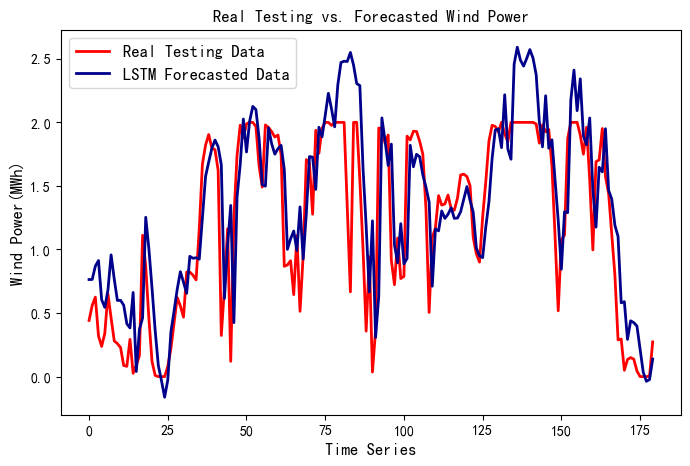

In [10]:
test_y, test_predict, loss_list, rmse, mae = train_lstm(batch_size, time_step, train_begin, train_end, test_begin, iter_time, test_len)

# 读取模型再保存模型的操作--完成

In [2]:
import tensorflow as tf

# 恢复原始模型的权重
with tf.Session() as sess:
    # 初始化变量
    sess.run(tf.global_variables_initializer())
    
    # 恢复原始模型
    saver = tf.compat.v1.train.import_meta_graph('./saved_model/model.meta')
    save_path = './saved_model/model'
    saver.restore(sess=sess, save_path=save_path)
    
    # 在这里添加需要的操作和计算
    
    # 创建一个新的 Saver 对象
    saver_ceshi = tf.train.Saver()
    
    # 保存模型到新路径
    save_pathceshi = './saved_model_ceshi/modelceshi'
    saver_ceshi.save(sess, save_pathceshi)

    print('tongg')



Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./saved_model/model

tongg


# 3：快速

In [1]:
# D:\a_study\model\chuneng\WindChaser-master - 副本\data
# 测试集和训练集的比例   7：3
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.metrics import mean_absolute_error,mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from numpy import shape
import matplotlib.ticker as ticker
%matplotlib inline
import math
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False


# 设置 TensorFlow 配置
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True  # 根据需要分配 GPU 内存
# 清理计算图
tf.compat.v1.reset_default_graph()
# 创建新的计算图
graph = tf.Graph()


#数据读取
df = pd.read_csv('data3.csv', on_bad_lines='skip')
print("Length of original data : ", len(df))
# 计算每小时的平均值并另存为新数据帧
data2 =[]   
for i in range (len(df)//12):
    data2.append(df[i * 12:(i + 1) * 12].mean())
data2 = pd.DataFrame(data2)
print("Length of hourly averaged data : ", len(data2))
# 6-11列的数据
data= data2.iloc[:, 5:11].values


# 相关参数
rnn_unit = 10      #隐藏层单元
input_size = 5     # 表示输入层为5，数据为6-11列，实际使用7-11做输入预测6的结果，可以理解为输入层有5个节点
output_size=1      # 表示输出层的维度是1，实际输出第6列的结果
lr=0.0006         # 学习率
batch_size = 14   # 每个batch中样本的数量
time_step = 12    # 每个样本输入的时间步数
# 大概占0.68306，简单理解成训练集和测试集7：3
train_begin = 0
train_end = math.ceil(len(data2) * 0.7)
test_begin = math.ceil(len(data2) * 0.7)
test_len = 180   # 测试数据的长度
# iter_time = 100  # 迭代次数
iter_time = 10  # 迭代次数
# RNN 输出节点权重和偏差
# 决定rnn单元的输出和下一步的状态
weights = {
           'in':tf.Variable(tf.random.normal([input_size,rnn_unit])),
           'out':tf.Variable(tf.random.normal([rnn_unit,1]))
           }

biases = {
          'in':tf.Variable(tf.constant(0.1,shape=[rnn_unit,])),
          'out':tf.Variable(tf.constant(0.1,shape=[1,]))
          }


# 获取训练数据功能：加载 LSTM 的训练数据
# 输入: batch_size, time_step, train_begin, train_end
# 输出: batch_index, train_x, train_y
def get_train_data(batch_size, time_step, train_begin, train_end):
    batch_index = []
    # 规范化数据
    scaler_for_x = MinMaxScaler(feature_range=(0, 1))
    scaled_x_data = scaler_for_x.fit_transform(data)
    scaler_for_y = MinMaxScaler(feature_range=(0, 1))
    scaled_y_data = scaler_for_y.fit_transform(data[:, 0].reshape(-1, 1))
    # 获得训练数据
    normalized_train_data = scaled_x_data[train_begin:train_end]
    train_x, train_y = [], []
    for i in range(len(normalized_train_data) - time_step):
        if i % batch_size == 0:
            batch_index.append(i)
        x = normalized_train_data[i:i + time_step, 1:6]
        y = normalized_train_data[i+1:i + time_step+1, 0, np.newaxis]
        train_x.append(x.tolist())
        train_y.append(y.tolist())
    batch_index.append((len(normalized_train_data) - time_step))
    return batch_index, train_x, train_y 


# 获取测试数据功能：LSTM 的负载测试数据
# 输入: time_step, test_begin, test_len
# 输出: test_x, test_y, scaler_for_x, scaler_for_y
def get_test_data(time_step, test_begin, test_len):
    # 规范化数据
    scaler_for_x = MinMaxScaler(feature_range=(0, 1))   # 归一化处理 minmaxscaler
    scaler_for_y = MinMaxScaler(feature_range=(0, 1))
    scaled_x_data = scaler_for_x.fit_transform(data)
    scaled_y_data = scaler_for_y.fit_transform(data[:, 0].reshape(-1, 1))
    # 获得测试数据
    size = test_len// time_step    # 用于计算测试集数据的数量
    normalized_test_data = scaled_x_data[test_begin: (test_begin+test_len)]
    normalized_test_lable = scaled_x_data[test_begin+1: (test_begin+test_len+1)]
    test_y = normalized_test_lable[:,0]
    test_x = []
    for i in range(size):
        x = normalized_test_data[i * time_step:(i + 1) * time_step, 1:6]
        test_x.append(x.tolist())
    return test_x, test_y, scaler_for_x, scaler_for_y


# LSTM 函数：循环神经网络的定义
# 输入: X
# 输出: pred, final_states
def lstm(X):
    batch_size = tf.shape(X)[0]
    time_step = tf.shape(X)[1]
    w_in = weights['in']
    b_in = biases['in']
    # reshape to (batch_size * time_step, input_size)
    input = tf.reshape(X, [-1, input_size])  #将张量转换为 3D 数组作为隐藏层的输入
    input_rnn = tf.matmul(input, w_in) + b_in
    input_rnn = tf.reshape(input_rnn, [-1, time_step, rnn_unit])
    # 创建要展开的 LSTM 单元
    cell = tf.contrib.rnn.BasicLSTMCell(rnn_unit)
    # 在每个时间步，重新初始化隐藏状态
    init_state = cell.zero_state(batch_size, dtype=tf.float32)
    # 生成预测
    # 在 TensorFlow 中创建一个动态 RNN 对象。
    # 此对象将在每个时间步长动态执行 LSTM 单元的展开
    output_rnn, final_states = tf.nn.dynamic_rnn(cell, input_rnn, initial_state=init_state,
                                                 dtype=tf.float32)
    output = tf.reshape(output_rnn, [-1, rnn_unit])
    w_out = weights['out']
    b_out = biases['out']
    ## 获取最后输出
    pred = tf.matmul(output, w_out) + b_out
    return pred, final_states


# train_lstm function: 训练 LSTM 模型、进行预测、计算预测误差
# 保存模型、读取上次训练的模型
# 输入: batch_size, time_step, train_begin, train_end, test_begin, iter_time, test_len
# 输出: test_y, test_predict, loss_list, rmse, mae
# test_y：测试集，test_predict：预测值
def train_lstm(batch_size, time_step, train_begin, train_end, test_begin, iter_time, test_len):
    # 设置状态存储/提取
    X = tf.placeholder(tf.float32, shape=[None, time_step, input_size], name='input_placeholder')
    Y = tf.placeholder(tf.float32, shape=[None, time_step, output_size])    
    batch_index, train_x, train_y = get_train_data(batch_size, time_step, train_begin, train_end)
    print("Training parameters:***************************************************")
    print("batch size: ", batch_size)
    print("Number of batches: ", len(batch_index))
    print("Shape of training samples:", shape(train_x))
    print("Shape of training labels:", shape(train_y))
    pred, _ = lstm(X)
    ## Loss and optimizer 损失和优化器
    loss = tf.reduce_mean(tf.square(tf.reshape(pred, [-1]) - tf.reshape(Y, [-1])))
    train_op = tf.train.AdamOptimizer(lr).minimize(loss)
    loss_list = []
    print("Training begins: *****************************************************")
    ## 训练步骤优化
    """
    累积损失以监控培训进度。
    20 次迭代通常足以达到可接受的精度。    
    """
    with tf.Session() as sess:
        # 初始化变量  必须要有
        sess.run(tf.global_variables_initializer())
        saver = tf.compat.v1.train.import_meta_graph('./saved_model/model.meta')
        save_path = './saved_model/model'
        # 恢复原始模型的权重
        saver.restore(sess=sess, save_path=save_path)
        # 获取原始模型的输入占位符、输出节点等  input_placeholder  my_pred
        graph = tf.compat.v1.get_default_graph()
        original_input = tf.compat.v1.get_default_graph().get_tensor_by_name('input_placeholder:0')  
        # 重复训练 100 次
        for epoch in range(iter_time):
            for step in range(len(batch_index) - 2):
                ## 计算批量损失 loss
                _, loss_ = sess.run([train_op, loss], feed_dict={X: train_x[batch_index[step]:batch_index[step + 1]],
                                                                 Y: np.array(train_y[batch_index[step]:batch_index[step + 1]], dtype=float).reshape(batch_size,time_step,1)})
                loss_list.append(loss_)
            # Show loss every 5 iterations   
            if epoch % 5 == 0:
                print("Epoch:", epoch, " loss:",loss_)
        # 生成了save_model文件夹,
        # D:\a_study\model\chuneng\WindChaser-master - 副本\saved_model
        saver = tf.train.Saver()

        # 保存模型
        saver.save(sess, 'saved_model/model')
        print("Training Optimization Finished! ***************************************")
        """Testing the model"""
        print("Prediction Begins: ****************************************************")
        test_x, test_y, scaler_for_x, scaler_for_y = get_test_data(time_step, test_begin, test_len)
        print("Shape of testing samples:", shape(test_x))     
        test_predict = []
        for step in range(len(test_x)):
            prob = sess.run(pred, feed_dict={X: [test_x[step]]})
            predict = prob.reshape((-1))
            test_predict.extend(predict)
        test_y = np.array(test_y).reshape(-1,1)
        test_predict = np.array(test_predict).reshape(-1,1) 
        print("Shape of testing lables:", shape(test_predict))
        test_predict = scaler_for_y.inverse_transform(test_predict).reshape(-1,1)
        test_y= scaler_for_y.inverse_transform(test_y).reshape(-1,1)
        #calculate the error of predication 
        rmse = np.sqrt(mean_squared_error(test_predict, test_y))
        mae = mean_absolute_error(y_pred=test_predict, y_true=test_y)
        print ("Mean absolute error:", "{:.3f}".format(mae), 
               "Root mean squared error:", "{:.3f}".format(rmse))
        # visualization
        figure = plt.figure(figsize=(8,5))
        axes = figure.add_subplot(1, 1, 1)
        axes.plot(test_y, lw='2', c = 'red', label='真实值')     
        axes.plot(test_predict, lw='2', c = 'darkblue', label='LSTM 预测值')
        axes.set_title('真实值 vs. 预测值 ', fontsize = 12)
        axes.set_xlabel('时间序列', fontsize = 12)
        axes.set_ylabel('风', fontsize = 12)
        axes.legend(fontsize=12)
    return test_y, test_predict, loss_list, rmse, mae

C:\Users\82516\.conda\envs\tf1\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\82516\.conda\envs\tf1\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\82516\.conda\envs\tf1\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\82516\.conda\envs\tf1\lib\site-packages\tensorflow\python\framework\dtypes.py:5

Length of original data :  17568
Length of hourly averaged data :  1464


In [2]:
test_y, test_predict, loss_list, rmse, mae = train_lstm(batch_size, time_step, train_begin, train_end, test_begin, iter_time, test_len)


Training parameters:***************************************************
batch size:  14
Number of batches:  74
Shape of training samples: (1013, 12, 5)
Shape of training labels: (1013, 12, 1)
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it t

ValueError: At least two variables have the same name: Variable/Adam

# bottom